For our previous example, we reduced the output of the PixelCNN to just 4 pixel lev‐
els to ensure the network didn’t have to learn a distribution over 256 independent
pixel values, which would slow the training process. However, this is far from ideal—
for color images, we wouldn’t want our canvas to be restricted to only a handful of
possible colors.

A mixture distribution is quite simply a mixture of two or
more other probability distributions. For example, we could have a mixture distribu‐
tion of five logistic distributions, each with different parameters. The mixture distri‐
bution also requires a discrete categorical distribution that denotes the probability of
choosing each of the distributions included in the mix.

To sample from a mixture distribution, we first sample from the categorical distribu‐
tion to choose a particular subdistribution and then sample from this in the usual
way. This way, we can create complex distributions with relatively few parameters.

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset using Tensorflow distributions

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import tensorflow_probability as tfp
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
N_COMPONENTS = 5
EPOCHS = 10
BATCH_SIZE = 128

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
# Preprocess the data


def preprocess(imgs):
    imgs = np.expand_dims(imgs, -1)
    imgs = tf.image.resize(imgs, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    return imgs


input_data = preprocess(x_train)

## 2. Build the PixelCNN <a name="build"></a>

Define the PixelCNN as a distribution—i.e., the output layer is a mixture distribution made up of five logistic distributions.

The input is a grayscale image of size 32 × 32 × 1.

The Model takes a grayscale image as input and outputs the log-likelihood of the
image under the mixture distribution calculated by the PixelCNN.

The loss function is the mean negative log-likelihood over the batch of input
images.

In [6]:
# Define a Pixel CNN network
dist = tfp.distributions.PixelCNN(
    image_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=N_COMPONENTS,
    dropout_p=0.3,
)

# Define the model input
image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Define the log likelihood for the loss fn
log_prob = dist.log_prob(image_input)

# Define the model
pixelcnn = models.Model(inputs=image_input, outputs=log_prob)
pixelcnn.add_loss(-tf.reduce_mean(log_prob))

## 3. Train the PixelCNN <a name="train"></a>

In [7]:
# Compile and train the model
pixelcnn.compile(
    optimizer=optimizers.Adam(0.001),
)

In [8]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def generate(self):
        return dist.sample(self.num_img).numpy()

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate()

        fig, axes = plt.subplots(1, self.num_img, figsize=(20, 4))
        for i, image in enumerate(generated_images):
            axes[i].imshow(image.squeeze(), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'Image {i+1}')
        plt.show()


img_generator_callback = ImageGenerator(num_img=2)

Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 2355.1677

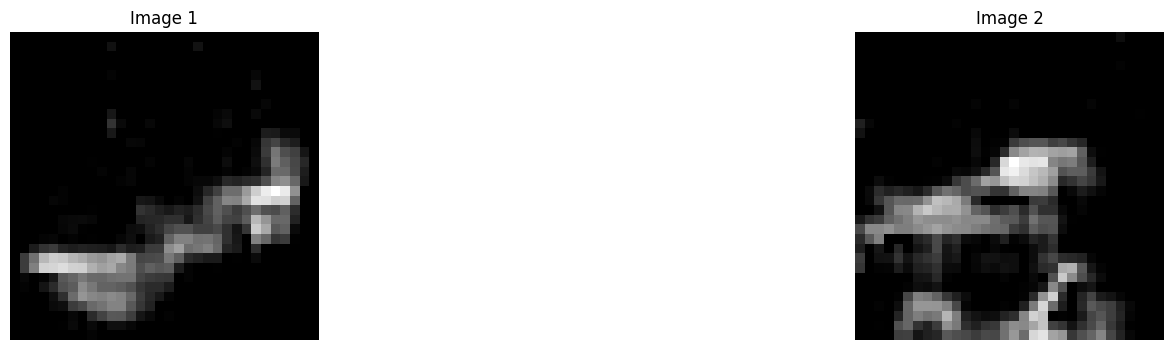

469/469 [==============================] - 229s 428ms/step - loss: 2355.1677
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 2073.7554

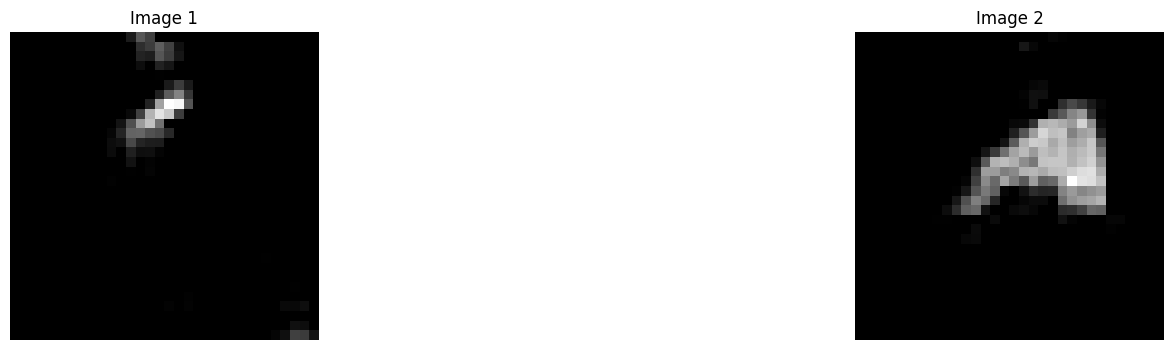

469/469 [==============================] - 197s 421ms/step - loss: 2073.7554
Epoch 3/10
469/469 [==============================] - ETA: 0s - loss: 1994.6581

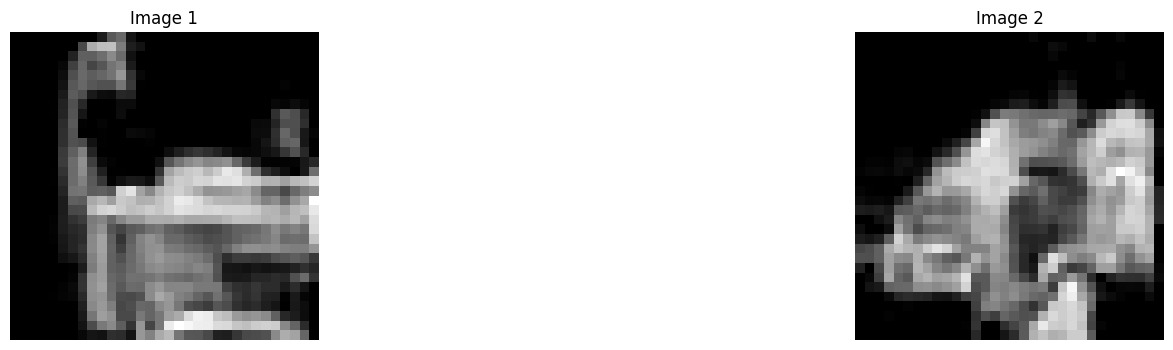

469/469 [==============================] - 198s 423ms/step - loss: 1994.6581
Epoch 4/10
469/469 [==============================] - ETA: 0s - loss: 1940.2885

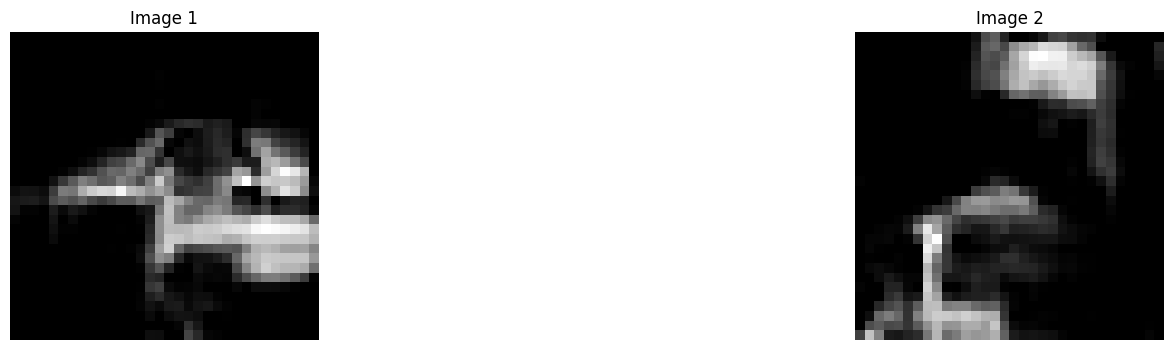

469/469 [==============================] - 198s 423ms/step - loss: 1940.2885
Epoch 5/10
469/469 [==============================] - ETA: 0s - loss: 1900.9115

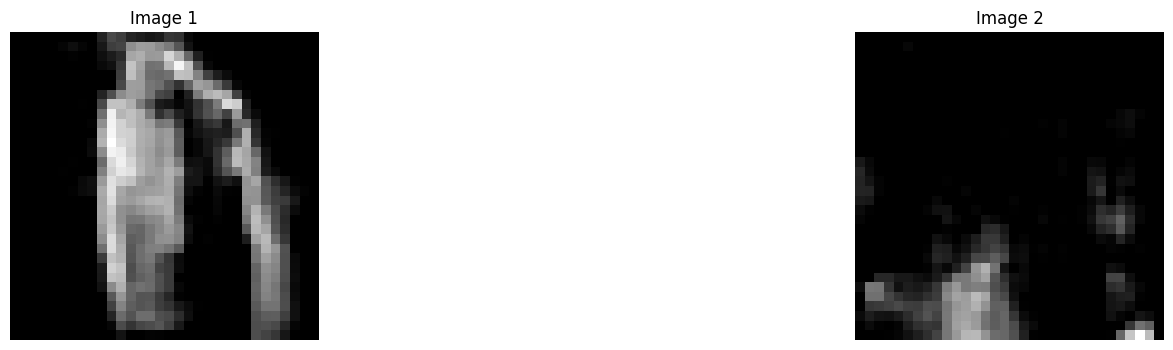

469/469 [==============================] - 198s 423ms/step - loss: 1900.9115
Epoch 6/10
469/469 [==============================] - ETA: 0s - loss: 1877.1271

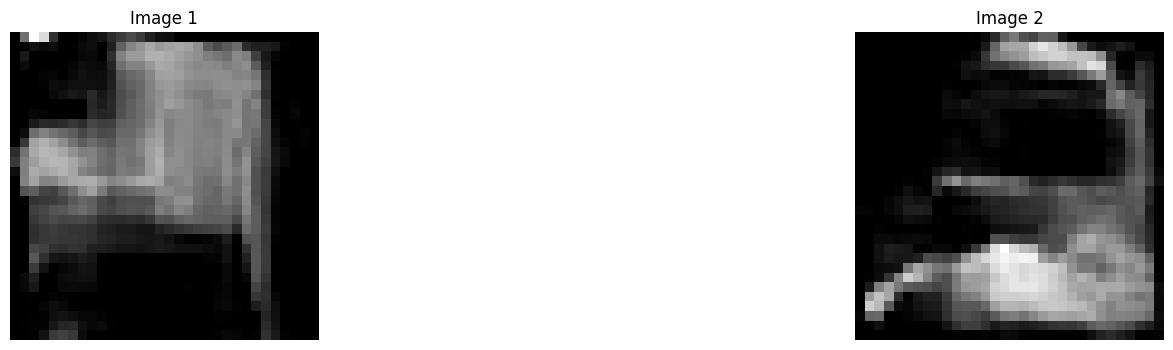

469/469 [==============================] - 199s 426ms/step - loss: 1877.1271
Epoch 7/10
469/469 [==============================] - ETA: 0s - loss: 1845.9977

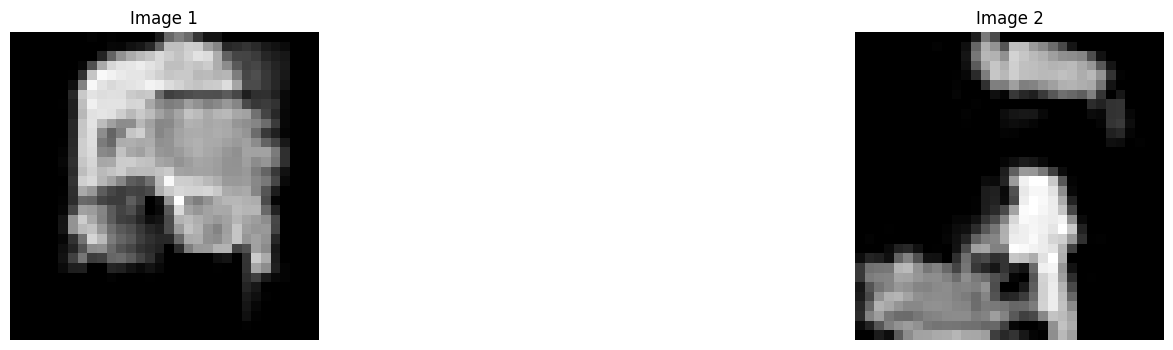

469/469 [==============================] - 200s 427ms/step - loss: 1845.9977
Epoch 8/10
469/469 [==============================] - ETA: 0s - loss: 1828.3345

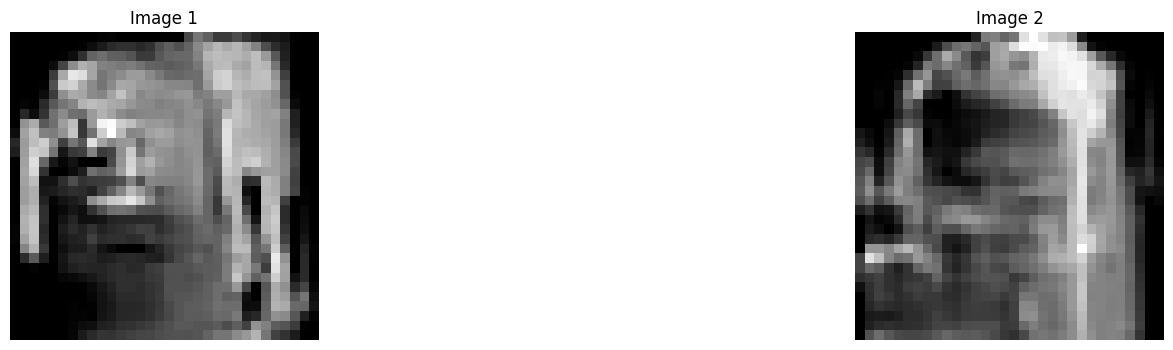

469/469 [==============================] - 198s 423ms/step - loss: 1828.3345
Epoch 9/10
469/469 [==============================] - ETA: 0s - loss: 1813.6304

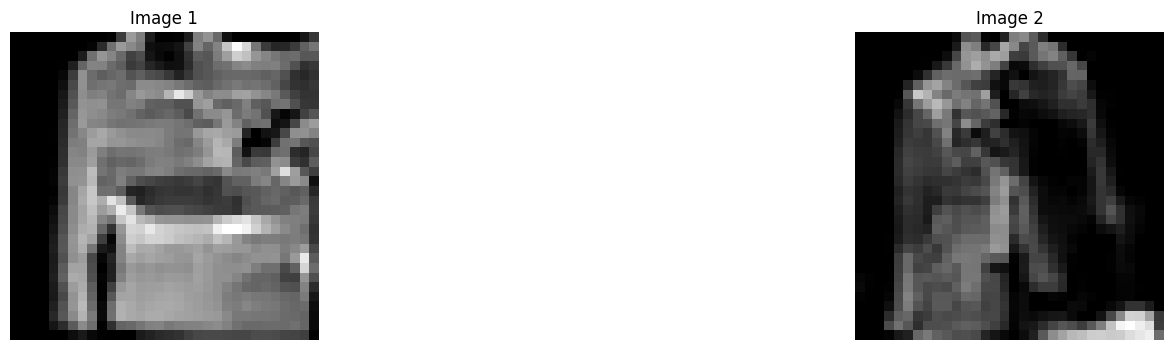

469/469 [==============================] - 199s 425ms/step - loss: 1813.6304
Epoch 10/10
469/469 [==============================] - ETA: 0s - loss: 1799.0564

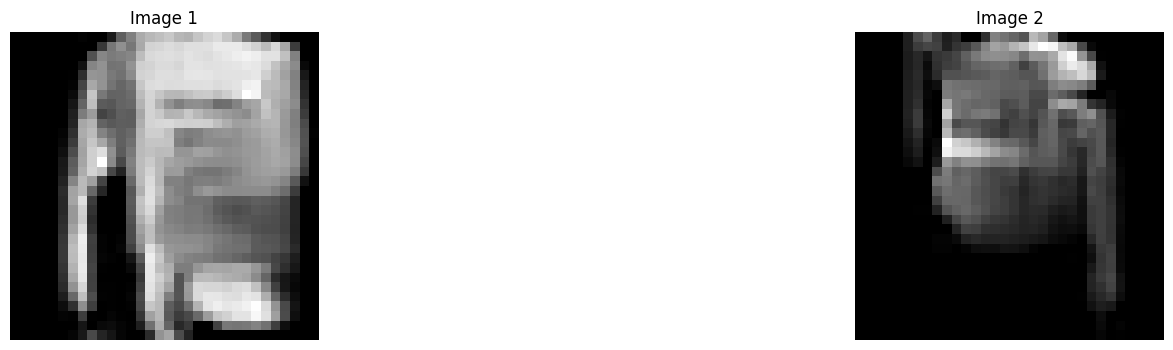

469/469 [==============================] - 199s 425ms/step - loss: 1799.0564


In [9]:
pixelcnn.fit(
    input_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    callbacks=[img_generator_callback],
)

## 4. Generate images <a name="generate"></a>

The difference from our previous examples is that now the full range of pixel values is being utilized.

In [10]:
generated_images = img_generator_callback.generate()

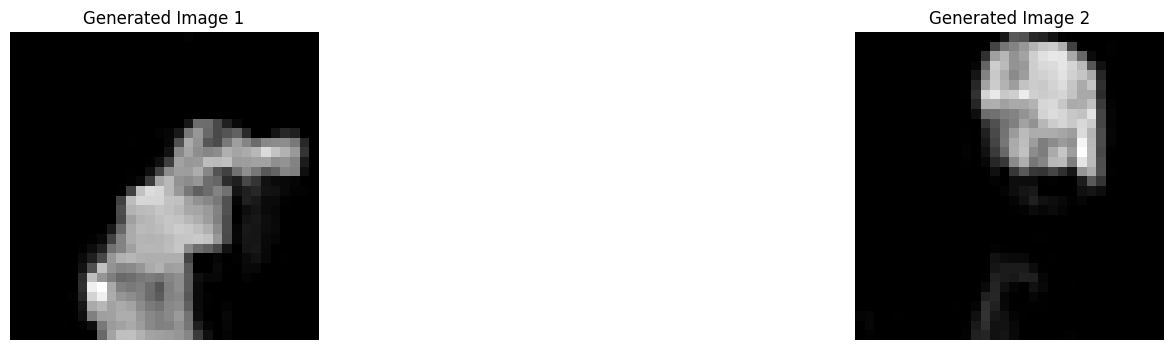

In [12]:
# Plot the generated images
num_img = generated_images.shape[0]
fig, axes = plt.subplots(1, num_img, figsize=(20, 4))

# Plot each generated image
for i in range(num_img):
    axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Generated Image {i+1}')

plt.show()

Looks like our model requires new training